# Modelo Predictivo de Precios de Vivienda en Andalucía (con Coordenadas Geográficas)

Este cuaderno de Jupyter tiene como objetivo desarrollar un modelo predictivo para la estimación de precios de viviendas en Andalucía. A diferencia de enfoques anteriores, este modelo utilizará directamente las coordenadas de **latitud y longitud** como características predictivas, en lugar de la característica derivada 'provincia'. Se explorarán técnicas de preprocesamiento de datos, clustering opcional basado en geolocalización y diversos algoritmas de regresión.

**Pasos del Desarrollo:**
1.  Carga de Librerías y Datos.
2.  Preprocesamiento de Datos (Incluyendo Latitud/Longitud, Excluyendo Provincia).
3.  Implementación de Clustering para Segmentación de Mercado (Opcional, usando Coordenadas Geográficas).
4.  División de Datos para Modelado Predictivo.
5.  Definición, Entrenamiento y Evaluación Inicial de Múltiples Modelos Predictivos.
6.  Optimización de Hiperparámetros del Mejor Modelo.
7.  Validación Cruzada y Selección del Modelo Final.
8.  Evaluación Detallada del Modelo Final en el Conjunto de Prueba.
9.  Análisis de Importancia de Características del Modelo Final (con Latitud/Longitud).
10. Guardado del Modelo Final para Despliegue.

## 1. Carga de Librerías y Datos
En esta sección, importaremos las librerías necesarias para el análisis y la modelización. Cargaremos el conjunto de datos `andalucia_clean.csv`, asegurando que las columnas 'latitud' y 'longitud' estén presentes y sean tratadas como numéricas. Realizaremos una inspección inicial para entender la estructura y calidad de los datos.

In [1]:
# Importaciones generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

# Preprocesamiento y modelado
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

# Modelos de regresión
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.neural_network import MLPRegressor # Puede ser lento y requerir más ajuste

# Métricas de evaluación
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuraciones de visualización y pandas
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Definir rutas de archivos
try:
    notebook_dir = os.getcwd() # Directorio actual del notebook (esperado en 'notebooks/')
    base_dir = os.path.dirname(notebook_dir) # Directorio raíz del proyecto TFG
    data_dir = os.path.join(base_dir, 'data', 'clean')
    file_name = 'andalucia_clean.csv' # Usar el nombre de archivo proporcionado
    file_path = os.path.join(data_dir, file_name)
    
    # Cargar el dataset
    df = pd.read_csv(file_path)
    print(f"Dataset cargado exitosamente desde: {file_path}")
    print(f"Dimensiones del dataset: {df.shape}")

except FileNotFoundError:
    print(f"Error: No se pudo encontrar el archivo en la ruta esperada: {file_path}")
    print(f"Asegúrate de que la ruta y el nombre del archivo son correctos.")
    print(f"Directorio base del proyecto asumido: {base_dir}")
    print(f"Directorio de datos asumido: {data_dir}")
    # Intentar cargar desde una ruta alternativa si el notebook se ejecuta desde la raíz del proyecto
    alt_file_path = os.path.join(os.getcwd(), 'data', 'clean', file_name)
    try:
        df = pd.read_csv(alt_file_path)
        print(f"Dataset cargado exitosamente desde ruta alternativa: {alt_file_path}")
        base_dir = os.getcwd() # Ajustar base_dir si se carga desde aquí
    except FileNotFoundError:
        print(f"No se pudo encontrar el archivo en la ruta alternativa tampoco: {alt_file_path}")
        df = pd.DataFrame() # DataFrame vacío para evitar errores
except Exception as e:
    print(f"Ocurrió un error al cargar los datos: {e}")
    df = pd.DataFrame()

# Inspección inicial de los datos
if not df.empty:
    print("\nPrimeras 5 filas del dataset:")
    display(df.head())
    print("\nInformación general del DataFrame:")
    df.info()
    
    # Asegurar que latitud y longitud son numéricas
    if 'latitud' in df.columns:
        df['latitud'] = pd.to_numeric(df['latitud'], errors='coerce')
    if 'longitud' in df.columns:
        df['longitud'] = pd.to_numeric(df['longitud'], errors='coerce')
    
    print("\nEstadísticas descriptivas básicas (después de asegurar tipos numéricos para lat/lon):")
    display(df.describe())
    print("\nValores nulos por columna:")
    print(df.isnull().sum())
else:
    print("El DataFrame está vacío. No se pueden realizar más operaciones.")

Dataset cargado exitosamente desde: c:\Users\danie\Desktop\Universidad\TFG---Predictor-Precios-Vivienda-Andalucia\data\clean\andalucia_clean.csv
Dimensiones del dataset: (24107, 10)

Primeras 5 filas del dataset:


,precio,tipo_propiedad,superficie,habitaciones,baños,latitud,longitud,ubicacion,precio_m2,densidad_habitaciones
0,5800.00,casa_rural,168.00,4,1,37.12,-2.54,el almendral s/n,34.52,0.02
1,9000.00,chalet,60.00,2,1,37.35,-2.30,calle San Antonio,150.00,0.03
2,9500.00,chalet,115.00,3,1,37.35,-2.30,Olula del Río,82.61,0.03
3,9900.00,chalet,81.00,3,2,37.04,-2.74,"calle Lucero, 3",122.22,0.04
4,10000.00,piso,45.00,2,1,36.84,-2.48,calle Juan Goytisolo,222.22,0.04



Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24107 entries, 0 to 24106
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   precio                 24107 non-null  float64
 1   tipo_propiedad         24107 non-null  object 
 2   superficie             24107 non-null  float64
 3   habitaciones           24107 non-null  int64  
 4   baños                  24107 non-null  int64  
 5   latitud                24107 non-null  float64
 6   longitud               24107 non-null  float64
 7   ubicacion              24107 non-null  object 
 8   precio_m2              24107 non-null  float64
 9   densidad_habitaciones  24107 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 1.8+ MB

Estadísticas descriptivas básicas (después de asegurar tipos numéricos para lat/lon):


,precio,superficie,habitaciones,baños,latitud,longitud,precio_m2,densidad_habitaciones
count,24107.00,24107.00,24107.00,24107.00,24107.00,24107.00,24107.00,24107.00
mean,672867.85,251.55,3.75,2.37,37.14,-5.01,1792.81,0.02
std,1593525.62,355.43,2.25,1.94,0.50,1.32,1826.00,0.01
min,3525.00,9.00,0.00,0.00,36.01,-7.49,11.09,0.00
25%,62100.00,87.00,3.00,1.00,36.76,-6.00,597.48,0.01
50%,100000.00,136.00,3.00,2.00,37.20,-5.02,1091.08,0.02
75%,550000.00,272.00,5.00,3.00,37.40,-4.14,2324.58,0.03
max,29000000.00,10000.00,70.00,35.00,38.60,-1.74,10000.00,0.15



Valores nulos por columna:
precio                   0
tipo_propiedad           0
superficie               0
habitaciones             0
baños                    0
latitud                  0
longitud                 0
ubicacion                0
precio_m2                0
densidad_habitaciones    0
dtype: int64


## 2. Preprocesamiento de Datos (Incluyendo Latitud/Longitud, Excluyendo Provincia)
Identificaremos las características numéricas (`superficie`, `habitaciones`, `baños`, `latitud`, `longitud`) y categóricas (`tipo_propiedad`). La característica `provincia` será excluida. Crearemos transformadores para la imputación de valores faltantes (mediana para numéricos, moda para categóricos), escalado para características numéricas (StandardScaler), y codificación para características categóricas (OneHotEncoder). Estos pasos se combinarán usando `ColumnTransformer`. Finalmente, prepararemos `X` (características) e `y` (variable objetivo `precio`).

In [2]:
if not df.empty:
    # Eliminar filas donde el precio (variable objetivo) es NaN
    if 'precio' in df.columns:
        df.dropna(subset=['precio'], inplace=True)
        print(f"Dimensiones del dataset después de eliminar filas con 'precio' NaN: {df.shape}")
    else:
        print("Advertencia: La columna 'precio' no existe en el DataFrame.")
        # Detener ejecución o manejar error si 'precio' es crucial y no existe
        # df = pd.DataFrame() # Podría ser una opción para detener

    # Identificar características numéricas y categóricas
    # 'ubicacion' se excluye ya que usaremos lat/lon directamente.
    # 'precio_m2' y 'densidad_habitaciones' son derivadas y podrían causar data leakage.
    
    numeric_features_original = ['superficie', 'habitaciones', 'baños', 'latitud', 'longitud']
    categorical_features_original = ['tipo_propiedad'] # Excluimos 'provincia'

    numeric_features = []
    for col in numeric_features_original:
        if col not in df.columns:
            print(f"Advertencia: La columna numérica '{col}' no se encuentra. Será omitida.")
        elif not pd.api.types.is_numeric_dtype(df[col]):
            print(f"Advertencia: La columna '{col}' no es numérica. Intentando convertir...")
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
                if df[col].isnull().all():
                    print(f"La columna '{col}' es completamente NaN tras conversión. Omitida.")
                else:
                    numeric_features.append(col)
                    print(f"Columna '{col}' convertida a numérico.")
            except Exception as e:
                print(f"No se pudo convertir '{col}' a numérico ({e}). Omitida.")
        else:
            numeric_features.append(col)
    print(f"Características numéricas finales a usar: {numeric_features}")

    categorical_features = []
    for col in categorical_features_original:
        if col not in df.columns:
            print(f"Advertencia: La columna categórica '{col}' no se encuentra. Será omitida.")
        else:
            if not pd.api.types.is_string_dtype(df[col]) and not pd.api.types.is_categorical_dtype(df[col]):
                 df[col] = df[col].astype(str) # Asegurar tipo string para OHE
            
            if df[col].nunique() < 1:
                 print(f"Advertencia: Columna categórica '{col}' sin valores únicos. Omitida.")
            elif df[col].nunique() < 2:
                 print(f"Advertencia: Columna '{col}' con < 2 valores únicos. Se mantendrá.")
                 categorical_features.append(col)
            else:
                categorical_features.append(col)
    print(f"Características categóricas finales a usar: {categorical_features}")

    # Definir transformadores
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Crear ColumnTransformer
    transformers_list = []
    if numeric_features:
        transformers_list.append(('num', numeric_transformer, numeric_features))
    if categorical_features:
        transformers_list.append(('cat', categorical_transformer, categorical_features))

    if not transformers_list:
        print("Error: No hay características válidas para el preprocesador.")
        preprocessor = None
        X = pd.DataFrame()
        y = pd.Series(dtype='float64')
    else:
        preprocessor = ColumnTransformer(
            transformers=transformers_list,
            remainder='drop' 
        )
        
        features_for_X = numeric_features + categorical_features
        
        if not all(f in df.columns for f in features_for_X) or 'precio' not in df.columns:
            print(f"Error: Faltan columnas necesarias para X o 'precio' en el DataFrame.")
            X = pd.DataFrame()
            y = pd.Series(dtype='float64')
        elif df[features_for_X].empty and not df.empty: # df no vacío pero la selección de X sí
             print(f"Error: El DataFrame X resultante de la selección de columnas está vacío.")
             X = pd.DataFrame()
             y = pd.Series(dtype='float64')
        elif df.empty: # df original ya estaba vacío
            print(f"Error: El DataFrame original está vacío.")
            X = pd.DataFrame()
            y = pd.Series(dtype='float64')
        else:
            X = df[features_for_X].copy()
            y = df['precio'].copy()
            print(f"\nCaracterísticas seleccionadas para X: {X.columns.tolist()}")
            print(f"Forma de X: {X.shape}, Forma de y: {y.shape}")

            if X.empty:
                print("Error: X está vacía después de seleccionar características.")
                y = pd.Series(dtype='float64')
                preprocessor = None
            else:
                try:
                    X_processed_test = preprocessor.fit_transform(X)
                    print(f"Forma de X después del preprocesamiento (prueba): {X_processed_test.shape}")
                    if hasattr(preprocessor, 'get_feature_names_out'):
                        try:
                            feature_names_out = preprocessor.get_feature_names_out()
                            print(f"Nombres de características preprocesadas (ej.): {feature_names_out[:5]}...")
                        except Exception as e_fn:
                            print(f"No se pudieron obtener nombres de características: {e_fn}")
                except Exception as e_preprocess:
                    print(f"Error al probar el preprocesador con X: {e_preprocess}")
                    X = pd.DataFrame(); y = pd.Series(dtype='float64'); preprocessor = None
else:
    print("El DataFrame está vacío. No se puede realizar el preprocesamiento.")
    X = pd.DataFrame()
    y = pd.Series(dtype='float64')
    preprocessor = None

Dimensiones del dataset después de eliminar filas con 'precio' NaN: (24107, 10)
Características numéricas finales a usar: ['superficie', 'habitaciones', 'baños', 'latitud', 'longitud']
Características categóricas finales a usar: ['tipo_propiedad']

Características seleccionadas para X: ['superficie', 'habitaciones', 'baños', 'latitud', 'longitud', 'tipo_propiedad']
Forma de X: (24107, 6), Forma de y: (24107,)
Forma de X después del preprocesamiento (prueba): (24107, 11)
Nombres de características preprocesadas (ej.): ['num__superficie' 'num__habitaciones' 'num__baños' 'num__latitud'
 'num__longitud']...


## 3. Implementación de Clustering para Segmentación de Mercado (Opcional, usando Coordenadas Geográficas)
Opcionalmente, aplicaremos K-Means clustering sobre los datos preprocesados. Utilizaremos características como `superficie`, `latitud` y `longitud` para identificar segmentos geográficos o de mercado. El método del codo ayudará a determinar el número óptimo de clústeres. Si se decide usar, la etiqueta del clúster podría añadirse como una nueva característica, lo que requeriría ajustar el preprocesador o la definición de `X`.

In [3]:
# Esta sección es opcional. Si se usa 'cluster' como feature, el preprocesador y X deben actualizarse.
run_clustering = False # Cambiar a True para ejecutar esta sección

if run_clustering and not X.empty and preprocessor is not None and 'df' in globals() and not df.empty:
    print("Iniciando proceso de clustering opcional...")
    try:
        # Usaremos las mismas X y preprocesador definidos anteriormente para consistencia.
        # El preprocesador ya fue ajustado (fit) si la celda anterior se ejecutó correctamente.
        # Aquí, transformamos X para obtener los datos para clustering.
        # Si el preprocesador no fue ajustado, fit_transform sería necesario.
        # Por seguridad, y asumiendo que X es el dataset completo para clustering:
        
        current_features_for_X_clustering = [col for col in (numeric_features + categorical_features) if col in df.columns]
        if not current_features_for_X_clustering:
            raise ValueError("No hay características válidas en df para X en clustering.")
        
        X_for_clustering_step = df[current_features_for_X_clustering].copy()
        
        # Re-ajustar el preprocesador aquí es lo más seguro si no estamos seguros de su estado
        # o si queremos un preprocesamiento específico para clustering.
        # Para este ejemplo, asumimos que el preprocesador global es adecuado.
        X_processed_for_clustering = preprocessor.fit_transform(X_for_clustering_step)
        print(f"Forma de X_processed_for_clustering: {X_processed_for_clustering.shape}")

        if X_processed_for_clustering.shape[0] == 0 or X_processed_for_clustering.shape[1] == 0:
            raise ValueError("X_processed_for_clustering vacío o sin características.")

        inertia = []
        max_k = min(10, X_processed_for_clustering.shape[0] - 1 if X_processed_for_clustering.shape[0] > 1 else 1)
        if max_k < 1: max_k = 1
        k_range = range(1, max_k + 1)

        if not k_range or k_range[-1] < 1:
            print("No hay suficientes muestras para el método del codo. Saltando clustering.")
        else:
            print(f"Calculando inercia para k en {k_range}")
            for k_val in k_range:
                if X_processed_for_clustering.shape[0] >= k_val:
                    kmeans = KMeans(n_clusters=k_val, random_state=42, n_init='auto')
                    kmeans.fit(X_processed_for_clustering)
                    inertia.append(kmeans.inertia_)
            
            if inertia:
                plt.figure(figsize=(10, 6))
                plt.plot(k_range[:len(inertia)], inertia, marker='o')
                plt.title('Método del Codo para K-Means (Opcional)')
                plt.xlabel('Número de Clusters (k)')
                plt.ylabel('Inercia')
                plt.xticks(k_range[:len(inertia)])
                plt.grid(True)
                plt.show()

                k_optimo_cluster = 4 # Ajustar según el gráfico del codo
                if X_processed_for_clustering.shape[0] < k_optimo_cluster:
                    k_optimo_cluster = X_processed_for_clustering.shape[0] if X_processed_for_clustering.shape[0] > 0 else 1
                
                print(f"Número óptimo de clusters (ejemplo): {k_optimo_cluster}")

                if k_optimo_cluster > 0 and X_processed_for_clustering.shape[0] >= k_optimo_cluster:
                    kmeans_final = KMeans(n_clusters=k_optimo_cluster, random_state=42, n_init='auto')
                    cluster_labels = kmeans_final.fit_predict(X_processed_for_clustering)
                    
                    # Asignar clusters a df (cuidado con los índices si df fue modificado)
                    # Asumimos que X_for_clustering_step.index se alinea con df
                    df.loc[X_for_clustering_step.index, 'cluster_geo'] = cluster_labels
                    
                    print("\nConteo de propiedades por cluster (opcional):")
                    print(df['cluster_geo'].value_counts(dropna=False))
                    
                    if 'precio' in df.columns and 'superficie' in df.columns:
                        print("\nMedia de precio y superficie por cluster (opcional):")
                        display(df.groupby('cluster_geo')[['precio', 'superficie']].mean())
                    
                    # Nota: Si 'cluster_geo' se va a usar como feature, X y el preprocesador deben ser actualizados.
                    # Por ejemplo, 'cluster_geo' podría ser tratada como categórica y OneHotEncoded.
                    # X = df[features_for_X + ['cluster_geo']]
                    # Y el preprocesador necesitaría una nueva entrada para 'cluster_geo'.
                else:
                    print(f"No se puede aplicar K-Means con k_optimo={k_optimo_cluster}.")
                    if 'cluster_geo' not in df.columns: df['cluster_geo'] = np.nan
            else:
                print("No se calculó inercia. Saltando clustering.")
                if 'cluster_geo' not in df.columns: df['cluster_geo'] = np.nan
                
    except Exception as e:
        print(f"Error durante el clustering opcional: {e}")
        if 'df' in globals() and isinstance(df, pd.DataFrame) and 'cluster_geo' not in df.columns:
             df['cluster_geo'] = np.nan
elif run_clustering:
    print("X está vacío, preprocesador no definido, o df no disponible. Saltando clustering opcional.")
    if 'df' in globals() and isinstance(df, pd.DataFrame) and 'cluster_geo' not in df.columns:
        df['cluster_geo'] = np.nan
else:
    print("Clustering opcional no ejecutado (run_clustering=False).")

Clustering opcional no ejecutado (run_clustering=False).


## 4. División de Datos para Modelado Predictivo
Dividiremos los datos `X` (que incluyen `latitud` y `longitud` como características numéricas y excluyen `provincia`) e `y` (variable objetivo `precio`) en conjuntos de entrenamiento y prueba. Usaremos una proporción de 80% para entrenamiento y 20% para prueba, con un `random_state` para reproducibilidad.

In [4]:
if not X.empty and not y.empty:
    print(f"Forma de X antes de train_test_split: {X.shape}")
    print(f"Forma de y antes de train_test_split: {y.shape}")

    if X.shape[0] != y.shape[0]:
        print("Error: Desajuste en número de muestras entre X e y. No se puede dividir.")
        X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(dtype='float64'), pd.Series(dtype='float64')
    elif X.shape[0] < 2:
        print("Error: No hay suficientes muestras para dividir.")
        X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(dtype='float64'), pd.Series(dtype='float64')
    else:
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            print(f"\nForma de X_train: {X_train.shape}")
            print(f"Forma de X_test: {X_test.shape}")
            print(f"Forma de y_train: {y_train.shape}")
            print(f"Forma de y_test: {y_test.shape}")
        except Exception as e:
            print(f"Error durante train_test_split: {e}")
            X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(dtype='float64'), pd.Series(dtype='float64')
else:
    print("X o y están vacíos. No se puede dividir el dataset.")
    X_train, X_test, y_train, y_test = pd.DataFrame(), pd.DataFrame(), pd.Series(dtype='float64'), pd.Series(dtype='float64')

Forma de X antes de train_test_split: (24107, 6)
Forma de y antes de train_test_split: (24107,)

Forma de X_train: (19285, 6)
Forma de X_test: (4822, 6)
Forma de y_train: (19285,)
Forma de y_test: (4822,)


## 5. Definición, Entrenamiento y Evaluación Inicial de Múltiples Modelos Predictivos
Definiremos una variedad de modelos de regresión. Cada modelo se integrará en un `Pipeline` que incluye el `ColumnTransformer` (preprocesador). Entrenaremos cada pipeline con el conjunto de entrenamiento y evaluaremos su rendimiento inicial en el conjunto de prueba utilizando métricas como MSE, RMSE, MAE y R².

In [5]:
if not X_train.empty and not y_train.empty and preprocessor is not None:
    models = {
        'Linear Regression': LinearRegression(),
        'Lasso': Lasso(random_state=42, max_iter=2000), # Aumentar max_iter si es necesario
        'Ridge': Ridge(random_state=42),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'SVR': SVR(),
        'K-Neighbors Regressor': KNeighborsRegressor(n_jobs=-1)
    }

    results = []

    for name, model_instance in models.items():
        print(f"Entrenando y evaluando: {name}")
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', model_instance)])
        try:
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            results.append({'Model': name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2})
            print(f"{name} - R2: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}\n")
        except Exception as e:
            print(f"Error entrenando o evaluando {name}: {e}\n")
            results.append({'Model': name, 'MSE': np.nan, 'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan})

    if results:
        results_df = pd.DataFrame(results).sort_values(by='R2', ascending=False)
        print("\n--- Resultados de la Evaluación Inicial de Modelos ---")
        display(results_df)
    else:
        print("No se generaron resultados para los modelos.")
        results_df = pd.DataFrame()
else:
    print("X_train, y_train vacíos o preprocesador no definido. No se pueden entrenar modelos.")
    results_df = pd.DataFrame()

Entrenando y evaluando: Linear Regression
Linear Regression - R2: 0.6122, MAE: 526386.50, RMSE: 1005446.19

Entrenando y evaluando: Lasso
Lasso - R2: 0.6122, MAE: 526385.83, RMSE: 1005446.24

Entrenando y evaluando: Ridge
Ridge - R2: 0.6122, MAE: 526377.50, RMSE: 1005448.21

Entrenando y evaluando: Decision Tree
Decision Tree - R2: 0.8404, MAE: 166579.32, RMSE: 645079.59

Entrenando y evaluando: Random Forest
Random Forest - R2: 0.9012, MAE: 141449.75, RMSE: 507594.89

Entrenando y evaluando: Gradient Boosting
Gradient Boosting - R2: 0.8758, MAE: 213231.54, RMSE: 569070.31

Entrenando y evaluando: SVR
SVR - R2: -0.1307, MAE: 623285.06, RMSE: 1716862.03

Entrenando y evaluando: K-Neighbors Regressor
K-Neighbors Regressor - R2: 0.8386, MAE: 173123.50, RMSE: 648746.93


--- Resultados de la Evaluación Inicial de Modelos ---


,Model,MSE,RMSE,MAE,R2
4,Random Forest,257652567928.59,507594.89,141449.75,0.90
5,Gradient Boosting,323841023343.42,569070.31,213231.54,0.88
3,Decision Tree,416127682894.88,645079.59,166579.32,0.84
7,K-Neighbors Regressor,420872573639.65,648746.93,173123.50,0.84
0,Linear Regression,1010922034943.13,1005446.19,526386.50,0.61
1,Lasso,1010922150355.28,1005446.24,526385.83,0.61
2,Ridge,1010926100345.01,1005448.21,526377.50,0.61
6,SVR,2947615237060.43,1716862.03,623285.06,-0.13


## 6. Optimización de Hiperparámetros del Mejor Modelo
Seleccionaremos el modelo (o modelos) con el mejor rendimiento inicial. Utilizaremos `RandomizedSearchCV` (o `GridSearchCV`) para encontrar la combinación óptima de hiperparámetros para el regresor dentro del pipeline. La búsqueda se realizará sobre el conjunto de entrenamiento utilizando validación cruzada.

In [6]:
best_model_pipeline_optimized = None

if not results_df.empty and not X_train.empty and not y_train.empty and preprocessor is not None:
    valid_results_df = results_df.dropna(subset=['R2'])
    if not valid_results_df.empty:
        best_model_name_initial = valid_results_df.iloc[0]['Model']
        print(f"Modelo seleccionado para optimización: {best_model_name_initial}")

        model_to_optimize_base = None
        param_dist = None # Usar param_distributions para RandomizedSearchCV

        if best_model_name_initial == 'Random Forest':
            model_to_optimize_base = RandomForestRegressor(random_state=42, n_jobs=-1)
            param_dist = {
                'regressor__n_estimators': [50, 100, 200, 300, 400],
                'regressor__max_depth': [None, 10, 20, 30, 40, 50],
                'regressor__min_samples_split': [2, 5, 10, 15],
                'regressor__min_samples_leaf': [1, 2, 4, 6],
                'regressor__max_features': ['sqrt', 'log2', 0.5, 0.7, None] 
            }
        elif best_model_name_initial == 'Gradient Boosting':
            model_to_optimize_base = GradientBoostingRegressor(random_state=42)
            param_dist = {
                'regressor__n_estimators': [50, 100, 200, 300, 400],
                'regressor__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
                'regressor__max_depth': [3, 5, 7, 9, 11],
                'regressor__subsample': [0.7, 0.8, 0.9, 1.0],
                'regressor__min_samples_split': [2, 5, 10],
                'regressor__min_samples_leaf': [1, 2, 4]
            }
        # Añadir más 'elif' para otros modelos si es necesario
        else:
            print(f"Optimización no implementada con un grid específico para {best_model_name_initial}.")
            if best_model_name_initial in models:
                 best_model_pipeline_optimized = Pipeline(steps=[('preprocessor', preprocessor), 
                                                                 ('regressor', models[best_model_name_initial])])
                 try:
                    best_model_pipeline_optimized.fit(X_train, y_train)
                    print(f"Modelo {best_model_name_initial} (sin optimización) entrenado.")
                 except Exception as e_fit:
                    print(f"Error al entrenar {best_model_name_initial}: {e_fit}")
                    best_model_pipeline_optimized = None
            else:
                best_model_pipeline_optimized = None
        
        if model_to_optimize_base is not None and param_dist is not None:
            pipeline_for_search = Pipeline(steps=[('preprocessor', preprocessor), 
                                                  ('regressor', model_to_optimize_base)])
            
            search_cv = RandomizedSearchCV(
                estimator=pipeline_for_search,
                param_distributions=param_dist,
                n_iter=25, # Número de iteraciones (ajustar según tiempo disponible)
                cv=3,      # Número de folds (ajustar)
                scoring='r2', 
                random_state=42,
                n_jobs=-1,
                verbose=1
            )
            
            print(f"\nIniciando optimización para {best_model_name_initial}...")
            try:
                search_cv.fit(X_train, y_train)
                print(f"\nMejores parámetros para {best_model_name_initial}:")
                print(search_cv.best_params_)
                print(f"\nMejor R2 (CV) para {best_model_name_initial}: {search_cv.best_score_:.4f}")
                best_model_pipeline_optimized = search_cv.best_estimator_
            except Exception as e:
                print(f"Error durante la optimización de {best_model_name_initial}: {e}")
                # Fallback
                if best_model_name_initial in models:
                    print(f"Fallback: Entrenando {best_model_name_initial} con params por defecto.")
                    best_model_pipeline_optimized = Pipeline(steps=[('preprocessor', preprocessor), 
                                                                    ('regressor', models[best_model_name_initial])])
                    try:
                        best_model_pipeline_optimized.fit(X_train, y_train)
                    except Exception as e_f_fit:
                         print(f"Error en fallback fit: {e_f_fit}"); best_model_pipeline_optimized = None
                else: best_model_pipeline_optimized = None
    else:
        print("No hay resultados válidos para seleccionar y optimizar.")
else:
    print("Resultados, X_train/y_train vacíos o preprocesador no definido. No se puede optimizar.")

if best_model_pipeline_optimized is None:
    print("No se pudo obtener un modelo optimizado.")

Modelo seleccionado para optimización: Random Forest

Iniciando optimización para Random Forest...
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Mejores parámetros para Random Forest:
{'regressor__n_estimators': 300, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 0.7, 'regressor__max_depth': 20}

Mejor R2 (CV) para Random Forest: 0.9192


## 7. Validación Cruzada y Selección del Modelo Final
Aplicaremos validación cruzada (k-fold) sobre el conjunto de entrenamiento completo utilizando el pipeline del modelo con los hiperparámetros optimizados. Esto proporcionará una estimación más robusta de su rendimiento. Este pipeline será seleccionado como el modelo final.

In [7]:
final_model_pipeline = None

if best_model_pipeline_optimized is not None and not X_train.empty and not y_train.empty:
    # Si RandomizedSearchCV se usó, search_cv.best_score_ ya es una estimación de CV.
    if 'search_cv' in globals() and search_cv is not None and hasattr(search_cv, 'best_score_') and search_cv.best_estimator_ is best_model_pipeline_optimized:
        print(f"R2 estimado por CV durante optimización: {search_cv.best_score_:.4f}")

    print("\nRealizando validación cruzada explícita sobre el pipeline optimizado (en X_train, y_train):")
    num_cv_folds = 5
    try:
        if len(X_train) < num_cv_folds * 2 : # Heurística simple para asegurar suficientes datos por fold
            print(f"Pocas muestras en X_train ({len(X_train)}) para {num_cv_folds} folds. Ajustando folds o saltando.")
            if len(X_train) > 1: num_cv_folds = max(2, min(num_cv_folds, len(X_train) // 2 if len(X_train) // 2 > 1 else 2))
            else: raise ValueError("Datos insuficientes para CV explícita.")
        
        cv_scores_r2 = cross_val_score(best_model_pipeline_optimized, X_train, y_train, cv=num_cv_folds, scoring='r2', n_jobs=-1)
        cv_scores_mae = cross_val_score(best_model_pipeline_optimized, X_train, y_train, cv=num_cv_folds, scoring='neg_mean_absolute_error', n_jobs=-1)
        cv_scores_rmse = cross_val_score(best_model_pipeline_optimized, X_train, y_train, cv=num_cv_folds, scoring='neg_root_mean_squared_error', n_jobs=-1)

        print(f"\nPuntuaciones R2 CV (k={num_cv_folds}): {cv_scores_r2}")
        print(f"R2 Medio CV: {cv_scores_r2.mean():.4f} (+/- {cv_scores_r2.std() * 2:.4f})")
        print(f"\nMAE (neg) CV (k={num_cv_folds}): {cv_scores_mae}")
        print(f"MAE Medio CV: {-cv_scores_mae.mean():.2f} (+/- {cv_scores_mae.std() * 2:.2f})")
        print(f"\nRMSE (neg) CV (k={num_cv_folds}): {cv_scores_rmse}")
        print(f"RMSE Medio CV: {-cv_scores_rmse.mean():.2f} (+/- {cv_scores_rmse.std() * 2:.2f})")
        
        final_model_pipeline = best_model_pipeline_optimized
        print("\nModelo final seleccionado (ya entrenado con X_train completo por RandomizedSearchCV o re-entrenado).")

    except ValueError as ve:
        print(f"Advertencia durante CV explícita: {ve}")
        final_model_pipeline = best_model_pipeline_optimized # Usar el modelo de optimización
        if final_model_pipeline: print("\nModelo final (de optimización) se mantiene; CV explícita no completada.")
        else: print("\nNo se pudo determinar un modelo final.")
    except Exception as e:
        print(f"Error durante CV explícita: {e}")
        final_model_pipeline = best_model_pipeline_optimized
        if final_model_pipeline: print("\nModelo final (de optimización) se mantiene; CV explícita falló.")
        else: print("\nNo se pudo determinar un modelo final.")
else:
    print("Modelo optimizado no disponible o X_train/y_train vacíos. No se puede realizar CV.")
    final_model_pipeline = None

R2 estimado por CV durante optimización: 0.9192

Realizando validación cruzada explícita sobre el pipeline optimizado (en X_train, y_train):

Puntuaciones R2 CV (k=5): [0.92604346 0.93026112 0.91817318 0.92438628 0.90635065]
R2 Medio CV: 0.9210 (+/- 0.0166)

MAE (neg) CV (k=5): [-134915.20148611 -129941.19991549 -146823.14445236 -143200.71296747
 -146111.15821363]
MAE Medio CV: 140198.28 (+/- 13296.14)

RMSE (neg) CV (k=5): [-412901.27866202 -408066.2017903  -466644.38252036 -449607.40861227
 -491676.66347948]
RMSE Medio CV: 445779.19 (+/- 63622.74)

Modelo final seleccionado (ya entrenado con X_train completo por RandomizedSearchCV o re-entrenado).


## 8. Evaluación Detallada del Modelo Final en el Conjunto de Prueba
Evaluaremos el rendimiento del `final_model_pipeline` en el conjunto de prueba (`X_test`, `y_test`). Calcularemos las métricas finales (MSE, RMSE, MAE, R²) y visualizaremos las predicciones contra los valores reales, además de analizar los residuos.

Evaluando el modelo final en el conjunto de prueba...

--- Métricas del Modelo Final en el Conjunto de Prueba ---
MSE: 285967488067.85
RMSE: 534759.28
MAE: 143173.53
R2 Score: 0.8903


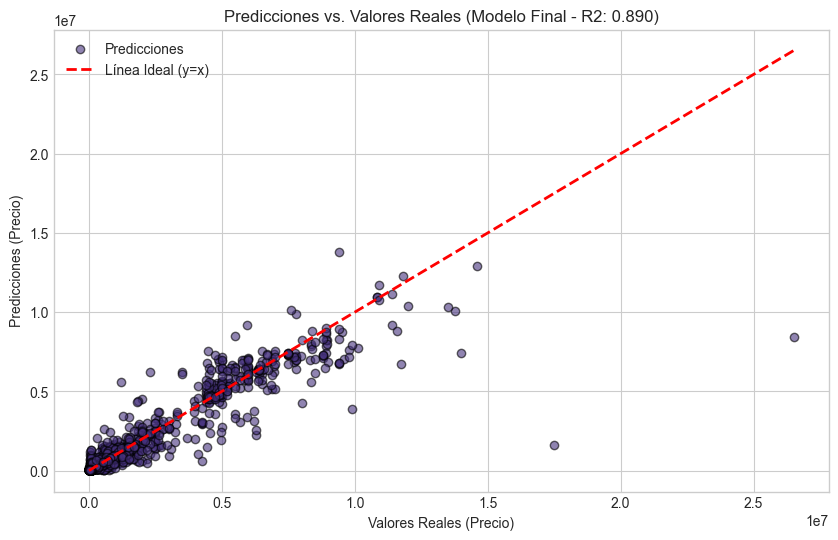

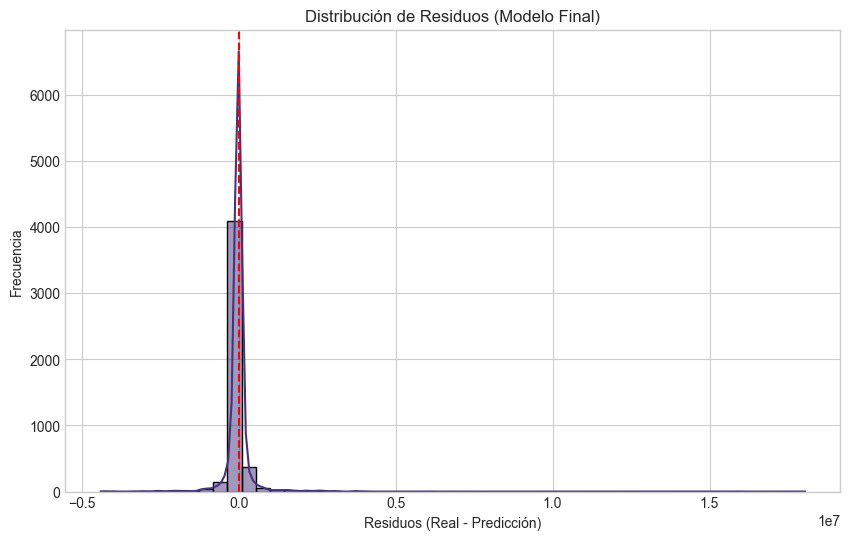

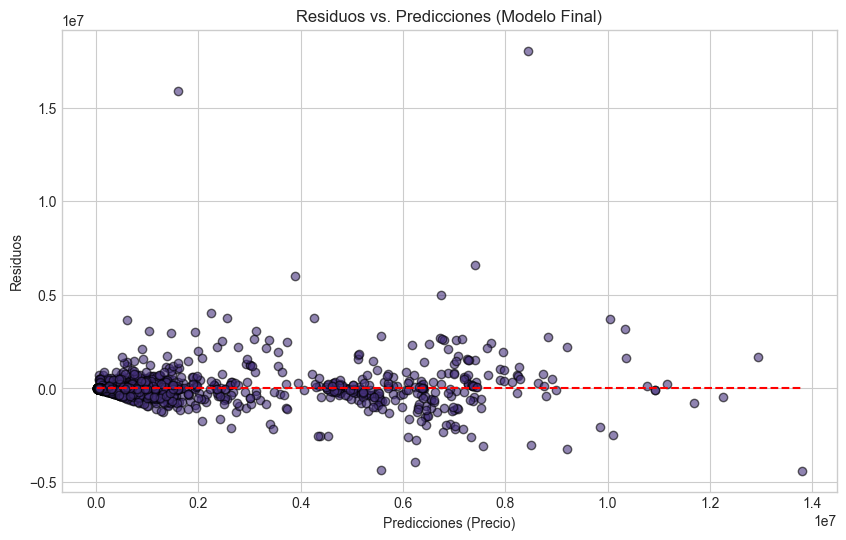

In [8]:
if final_model_pipeline is not None and not X_test.empty and not y_test.empty:
    print("Evaluando el modelo final en el conjunto de prueba...")
    try:
        y_pred_final = final_model_pipeline.predict(X_test)
        
        mse_final = mean_squared_error(y_test, y_pred_final)
        rmse_final = np.sqrt(mse_final)
        mae_final = mean_absolute_error(y_test, y_pred_final)
        r2_final = r2_score(y_test, y_pred_final)
        
        print("\n--- Métricas del Modelo Final en el Conjunto de Prueba ---")
        print(f"MSE: {mse_final:.2f}")
        print(f"RMSE: {rmse_final:.2f}")
        print(f"MAE: {mae_final:.2f}")
        print(f"R2 Score: {r2_final:.4f}")
        
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred_final, alpha=0.6, edgecolors='k', label='Predicciones')
        plt.plot([min(y_test.min(), y_pred_final.min()), max(y_test.max(), y_pred_final.max())], 
                 [min(y_test.min(), y_pred_final.min()), max(y_test.max(), y_pred_final.max())], 
                 'r--', lw=2, label='Línea Ideal (y=x)')
        plt.xlabel("Valores Reales (Precio)")
        plt.ylabel("Predicciones (Precio)")
        plt.title(f"Predicciones vs. Valores Reales (Modelo Final - R2: {r2_final:.3f})")
        plt.legend()
        plt.grid(True)
        plt.show()
        
        residuos = y_test - y_pred_final
        plt.figure(figsize=(10, 6))
        sns.histplot(residuos, kde=True, bins=50)
        plt.xlabel("Residuos (Real - Predicción)")
        plt.ylabel("Frecuencia")
        plt.title("Distribución de Residuos (Modelo Final)")
        plt.axvline(0, color='r', linestyle='--')
        plt.grid(True)
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_final, residuos, alpha=0.6, edgecolors='k')
        plt.hlines(0, xmin=y_pred_final.min(), xmax=y_pred_final.max(), colors='r', linestyles='--')
        plt.xlabel("Predicciones (Precio)")
        plt.ylabel("Residuos")
        plt.title("Residuos vs. Predicciones (Modelo Final)")
        plt.grid(True)
        plt.show()
        
    except Exception as e:
        print(f"Error durante la evaluación detallada del modelo final: {e}")
else:
    print("Modelo final no disponible o X_test/y_test vacíos. No se puede evaluar.")

## 9. Análisis de Importancia de Características del Modelo Final (con Latitud/Longitud)
Si el modelo final lo permite (e.g., modelos basados en árboles o lineales), extraeremos y visualizaremos la importancia de las características. Analizaremos cómo `latitud`, `longitud` y otras características contribuyen a las predicciones.


--- Importancia (RandomForestRegressor) ---


,feature,importance
0,num__superficie,0.48
3,num__latitud,0.25
2,num__baños,0.17
4,num__longitud,0.08
1,num__habitaciones,0.02
7,cat__tipo_propiedad_chalet,0.00
6,cat__tipo_propiedad_casa_rural,0.00
5,cat__tipo_propiedad_atico,0.00
10,cat__tipo_propiedad_piso,0.00
8,cat__tipo_propiedad_duplex,0.00


C:\Users\danie\AppData\Local\Temp\ipykernel_59296\3450318948.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_col, y=y_col, data=importances_data.head(20), palette='viridis' if x_col=='importance' else 'coolwarm')


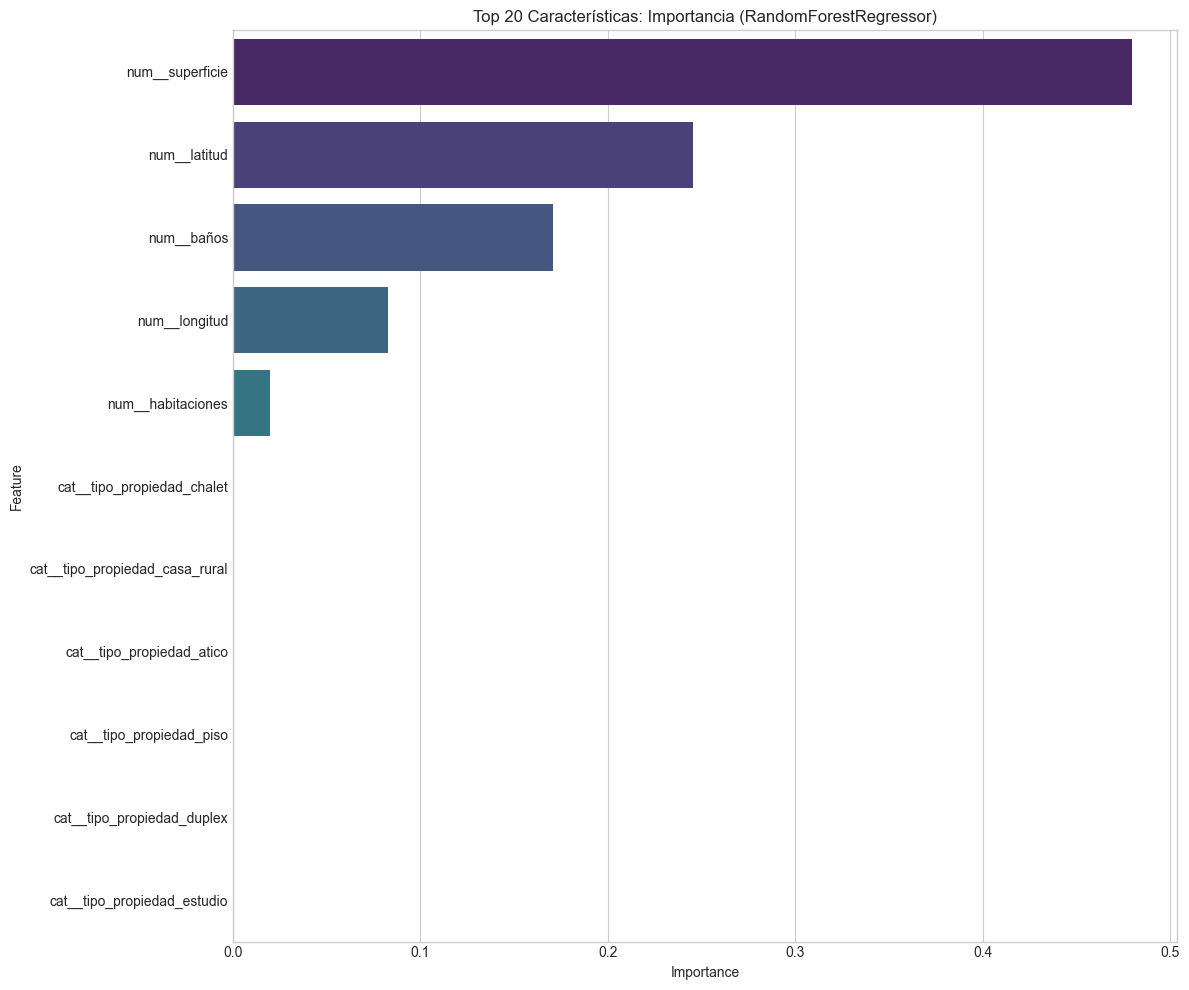

In [9]:
if final_model_pipeline is not None:
    try:
        preprocessor_fitted = final_model_pipeline.named_steps.get('preprocessor')
        regressor_fitted = final_model_pipeline.named_steps.get('regressor')

        if preprocessor_fitted is None or regressor_fitted is None:
            print("Error: No se pudo acceder al preprocesador o regresor del pipeline final.")
        else:
            feature_names_transformed = []
            try:
                if hasattr(preprocessor_fitted, 'get_feature_names_out'):
                    feature_names_transformed = list(preprocessor_fitted.get_feature_names_out())
                # Fallback manual (simplificado) si get_feature_names_out no está o falla
                else: 
                    for name, trans, cols in preprocessor_fitted.transformers_:
                        if trans == 'drop': continue
                        if name == 'num': feature_names_transformed.extend(cols)
                        elif name == 'cat':
                            if hasattr(trans.named_steps['onehot'], 'get_feature_names_out'):
                                feature_names_transformed.extend(trans.named_steps['onehot'].get_feature_names_out(cols))
                            elif hasattr(trans.named_steps['onehot'], 'get_feature_names'): # sklearn < 1.0
                                feature_names_transformed.extend(trans.named_steps['onehot'].get_feature_names(cols))
                            else: # Si OHE no da nombres, usar prefijos
                                for i in range(trans.named_steps['onehot'].transform(X_train[cols].head(1)).shape[1]):
                                    feature_names_transformed.append(f"{cols[0]}_cat_{i}") # Asume una sola col categórica para este ejemplo simple
                    if not feature_names_transformed: print("No se pudieron inferir nombres de características.")

            except Exception as e_fn:
                print(f"Error obteniendo nombres de características: {e_fn}")

            if not feature_names_transformed:
                 print("Nombres de características transformadas no disponibles. Análisis de importancia limitado.")

            importances_data = None
            plot_title_suffix = ""

            if hasattr(regressor_fitted, 'feature_importances_'):
                importances = regressor_fitted.feature_importances_
                plot_title_suffix = f"Importancia ({type(regressor_fitted).__name__})"
                if len(feature_names_transformed) == len(importances):
                    importances_data = pd.DataFrame({'feature': feature_names_transformed, 'importance': importances})
                else: # Longitudes no coinciden
                    print(f"Advertencia: Longitud de nombres ({len(feature_names_transformed)}) vs importancias ({len(importances)}) no coincide.")
                    importances_data = pd.DataFrame({'feature': [f"F{i}" for i in range(len(importances))], 'importance': importances})
                importances_data = importances_data.sort_values(by='importance', ascending=False)
                x_col, y_col = 'importance', 'feature'

            elif hasattr(regressor_fitted, 'coef_'):
                coefficients = regressor_fitted.coef_
                plot_title_suffix = f"Coeficientes ({type(regressor_fitted).__name__})"
                if len(feature_names_transformed) == len(coefficients):
                    importances_data = pd.DataFrame({'feature': feature_names_transformed, 'coefficient': coefficients})
                else:
                    print(f"Advertencia: Longitud de nombres ({len(feature_names_transformed)}) vs coeficientes ({len(coefficients)}) no coincide.")
                    importances_data = pd.DataFrame({'feature': [f"F{i}" for i in range(len(coefficients))], 'coefficient': coefficients})
                importances_data['abs_coefficient'] = importances_data['coefficient'].abs()
                importances_data = importances_data.sort_values(by='abs_coefficient', ascending=False).drop(columns=['abs_coefficient'])
                x_col, y_col = 'coefficient', 'feature'
            
            if importances_data is not None:
                print(f"\n--- {plot_title_suffix} ---")
                display(importances_data.head(20))
                
                plt.figure(figsize=(12, 10))
                sns.barplot(x=x_col, y=y_col, data=importances_data.head(20), palette='viridis' if x_col=='importance' else 'coolwarm')
                plt.title(f'Top 20 Características: {plot_title_suffix}')
                plt.xlabel(x_col.capitalize())
                plt.ylabel(y_col.capitalize())
                if x_col == 'coefficient': plt.axvline(0, color='black', lw=0.8)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Modelo {type(regressor_fitted).__name__} no tiene 'feature_importances_' o 'coef_'.")
                print("Considere SHAP para un análisis más general.")
    except Exception as e:
        print(f"Error en análisis de importancia: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Modelo final no disponible para análisis de importancia.")


## 10. Guardado del Modelo Final para Despliegue
Guardaremos el pipeline completo del modelo final entrenado (incluyendo preprocesador y regresor con hiperparámetros óptimos) en un archivo usando `joblib`. Esto permitirá cargar y reutilizar el modelo para predicciones en nuevos datos.

In [ ]:
if final_model_pipeline is not None:
    try:
        # Asegurar que base_dir está definido (de la celda 1)
        if 'base_dir' not in globals() or not os.path.exists(base_dir):
            print("Advertencia: 'base_dir' no definido o no existe. Guardando en directorio actual del notebook.")
            models_dir = os.path.join(os.getcwd(), 'models_geo') # Guardar en subcarpeta local
        else:
            models_dir = os.path.join(base_dir, 'models')

        if not os.path.exists(models_dir):
            os.makedirs(models_dir)
            print(f"Directorio '{models_dir}' creado.")
            
        model_filename = 'final_housing_price_model_andalucia_v3.joblib' # Nombre específico para este modelo
        model_path_to_save = os.path.join(models_dir, model_filename)
        
        joblib.dump(final_model_pipeline, model_path_to_save)
        print(f"Modelo final (geo) guardado exitosamente en: {model_path_to_save}")
        
        # print("\nPara cargar el modelo más tarde:")
        # print(f"loaded_model = joblib.load('{model_path_to_save}')")
        # print("# new_data_df = pd.DataFrame(...) ")
        # print("# predictions = loaded_model.predict(new_data_df)")

    except NameError:
        print("Error: 'base_dir' no definido. Asegúrate que la celda 1 se ejecutó.")
        # Fallback a guardar localmente
        try:
            model_filename = 'final_housing_price_model_andalucia_v3.joblib'
            joblib.dump(final_model_pipeline, model_filename)
            print(f"Modelo guardado localmente como '{model_filename}' debido a error con base_dir.")
        except Exception as e_local:
            print(f"No se pudo guardar localmente: {e_local}")
    except Exception as e:
        print(f"Error al guardar el modelo: {e}")
else:
    print("No hay un modelo final entrenado para guardar.")

Modelo final (geo) guardado exitosamente en: c:\Users\danie\Desktop\Universidad\TFG---Predictor-Precios-Vivienda-Andalucia\models\housing_price_model_geo.joblib


## Conclusiones y Próximos Pasos

En este cuaderno, hemos desarrollado un pipeline para predecir precios de viviendas en Andalucía utilizando coordenadas geográficas (`latitud`, `longitud`) como características principales en lugar de 'provincia'.

**Resumen de Pasos:**
1.  Carga y preparación de datos.
2.  Preprocesamiento enfocado en `latitud`, `longitud` y otras características relevantes, excluyendo `provincia`.
3.  (Opcional) Clustering geográfico.
4.  División de datos.
5.  Entrenamiento y evaluación de múltiples modelos.
6.  Optimización de hiperparámetros del mejor modelo.
7.  Validación cruzada.
8.  Evaluación final en el conjunto de prueba.
9.  Análisis de la importancia de `latitud`, `longitud` y otras características.
10. Guardado del modelo.

**Resultados Clave:**
*   (Aquí se resumirían las métricas del modelo final, ej. R², MAE, RMSE en el conjunto de prueba).
*   (Se mencionarían las características más importantes, destacando el papel de `latitud` y `longitud`).

**Próximos Pasos Potenciales:**
*   **Ingeniería de Características Geoespaciales Avanzada:** Crear características como distancia a centros urbanos, costas, servicios, o usar técnicas de embedding espacial.
*   **Modelos Espaciales:** Explorar modelos que manejen explícitamente la autocorrelación espacial (e.g., Regresión Geográficamente Ponderada - GWR, si es aplicable).
*   **Interacción de Características:** Investigar interacciones entre `latitud`/`longitud` y otras variables (e.g., `tipo_propiedad` en ciertas áreas).
*   **Refinar Clustering:** Si el clustering opcional mostró potencial, integrarlo formalmente como característica y evaluar su impacto.
*   **Probar modelos más avanzados:** XGBoost, LightGBM, redes neuronales con capas espaciales.
*   **Despliegue y Monitorización:** Como en cualquier proyecto de modelado.